In [114]:
import ete3
import treeCl
import os
import re
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform

%cd /work/nif/tree_dist

/work/nif/tree_dist


In [65]:
proteo = pd.read_table('/work/nif/proteo_info.tab', index_col=0)

In [99]:
def prepare_alignment_file(filename):
    alignment        = open(filename).read()
    all_genomes      = re.findall('^>(\S+?)\|', alignment, re.M)
    alignment_blocks = alignment.split('>') # split multiFASTA into single blocks using the ">" header starter
    alignment_blocks.pop(0) # since the file starts with a ">" the first element will always be empty

    #
    # create file with a treeCl-happy extension: ".fas"
    out = open('/work/nif/tree_dist/alignments/%s.fas' % os.path.basename(os.path.splitext(filename)[0]), 'wb')
    for block in alignment_blocks:
        block    = block.split('\n')    #separate header (only element before linebreak) from sequence (everything else)
        header   = block[0].split('|')[0]   #use only the GENOME part from the header (GENOME|GENE)
        if all_genomes.count(header) != 1:
            continue
        sequence = '\n'.join(block[1:])
        out.write('>%s\n%s' %(proteo.loc[re.sub('[.-]', '', header), 'taxid'], sequence))
    out.close()

def prepare_tree_file(filename):
    tree        = ete3.Tree('%s.treefile' % filename, format=1)
    all_genomes = [leaf.split('|')[0] for leaf in tree.get_leaf_names()]
    single_copies = []
    for leaf in tree.get_leaves():
        genome = leaf.name.split('|')[0]
        if all_genomes.count(genome) != 1:
            continue
        leaf.name = genome.replace('_', '')
        single_copies.append(genome)
    
    tree.prune(single_copies, preserve_branch_length=True)
    tree.write(outfile='/work/nif/tree_dist/trees/%s.nwk' %os.path.basename(os.path.splitext(filename)[0]),
               format=5, dist_formatter='%.20f')

def prepare_data(group):
    alignment        = open('/work/nif/control_reconciliations/%s/%s.aln' % (group, group)).read()
    all_taxa         = re.findall('^>(\S+)', alignment, re.M)
    all_genomes      = re.findall('^>(\S+?)\|', alignment, re.M)
    alignment_blocks = alignment.split('>') # split multiFASTA into single blocks using the ">" header starter
    alignment_blocks.pop(0) # since the file starts with a ">" the first element will always be empty

    #
    # create file with a treeCl-happy extension: ".fas"
    out = open('/work/nif/tree_dist/alignments/%s.fas' % group, 'wb')
    for block in alignment_blocks:
        block    = block.split('\n')    #separate header (only element before linebreak) from sequence (everything else)
        header   = block[0].split('|')[0]   #use only the GENOME part from the header (GENOME|GENE)
        if all_genomes.count(header) != 1:
            continue
        sequence = '\n'.join(block[1:])
        out.write('>%s\n%s' %(proteo.loc[re.sub('[.-]', '', header), 'taxid'], sequence))
    out.close()

    tree_text   = open('/work/nif/control_reconciliations/%s/%s.aln.treefile' % (group, group)).read()
    for taxa in all_taxa:
        tree_text = tree_text.replace(taxa.replace('|', '_'), taxa)
    tree        = ete3.Tree(tree_text, format=1)
    single_copies = []
    for leaf in tree.get_leaves():
        genome = leaf.name.split('|')[0]
        if all_genomes.count(genome) != 1:
            continue
        leaf.name = str(proteo.loc[re.sub('[.-]', '', genome), 'taxid'])
        single_copies.append(leaf.name)

    tree.prune(single_copies, preserve_branch_length=True)
    tree.write(outfile='/work/nif/tree_dist/trees/%s.nwk' %group,
               format=5, dist_formatter='%.20f')

In [100]:
groups = 'Proteo_1010 Proteo_1596 Proteo_1952 Proteo_2186 Proteo_2312 Proteo_2513 Proteo_2778\
          Proteo_3012 Proteo_3479 Proteo_4355 Proteo_4806 Proteo_603  Proteo_8392 Proteo_1034\
          Proteo_1639 Proteo_1984 Proteo_2206 Proteo_2313 Proteo_2521 Proteo_2814 Proteo_3115\
          Proteo_3535 Proteo_4431 Proteo_4977 Proteo_617  Proteo_865  Proteo_1058 Proteo_1698\
          Proteo_2005 Proteo_2218 Proteo_2336 Proteo_2542 Proteo_2831 Proteo_3117 Proteo_3572\
          Proteo_4530 Proteo_5209 Proteo_6176 Proteo_9216 Proteo_106  Proteo_1760 Proteo_2006\
          Proteo_2225 Proteo_2341 Proteo_2557 Proteo_2842 Proteo_3155 Proteo_3636 Proteo_454 \
          Proteo_53   Proteo_640  Proteo_9507 Proteo_1157 Proteo_1764 Proteo_2080 Proteo_2230\
          Proteo_2373 Proteo_2644 Proteo_2863 Proteo_3255 Proteo_387  Proteo_4593 Proteo_5463\
          Proteo_652  Proteo_1245 Proteo_1771 Proteo_2081 Proteo_2245 Proteo_2394 Proteo_2688\
          Proteo_2885 Proteo_3312 Proteo_3901 Proteo_4657 Proteo_578  Proteo_72   Proteo_1514\
          Proteo_180  Proteo_2131 Proteo_2246 Proteo_2396 Proteo_2717 Proteo_2906 Proteo_3317\
          Proteo_3903 Proteo_4693 Proteo_5917 Proteo_7746 Proteo_1530 Proteo_1899 Proteo_2166\
          Proteo_2264 Proteo_2457 Proteo_2771 Proteo_3004 Proteo_3442 Proteo_410  Proteo_478 \
          Proteo_5918 Proteo_7809'.split()

for group in groups:
    print group
    prepare_data(group)

Proteo_1010
Proteo_1596
Proteo_1952
Proteo_2186
Proteo_2312
Proteo_2513
Proteo_2778
Proteo_3012
Proteo_3479
Proteo_4355
Proteo_4806
Proteo_603
Proteo_8392
Proteo_1034
Proteo_1639
Proteo_1984
Proteo_2206
Proteo_2313
Proteo_2521
Proteo_2814
Proteo_3115
Proteo_3535
Proteo_4431
Proteo_4977
Proteo_617
Proteo_865
Proteo_1058
Proteo_1698
Proteo_2005
Proteo_2218
Proteo_2336
Proteo_2542
Proteo_2831
Proteo_3117
Proteo_3572
Proteo_4530
Proteo_5209
Proteo_6176
Proteo_9216
Proteo_106
Proteo_1760
Proteo_2006
Proteo_2225
Proteo_2341
Proteo_2557
Proteo_2842
Proteo_3155
Proteo_3636
Proteo_454
Proteo_53
Proteo_640
Proteo_9507
Proteo_1157
Proteo_1764
Proteo_2080
Proteo_2230
Proteo_2373
Proteo_2644
Proteo_2863
Proteo_3255
Proteo_387
Proteo_4593
Proteo_5463
Proteo_652
Proteo_1245
Proteo_1771
Proteo_2081
Proteo_2245
Proteo_2394
Proteo_2688
Proteo_2885
Proteo_3312
Proteo_3901
Proteo_4657
Proteo_578
Proteo_72
Proteo_1514
Proteo_180
Proteo_2131
Proteo_2246
Proteo_2396
Proteo_2717
Proteo_2906
Proteo_3317
Proteo

In [72]:
def prepare_alignment_file(filename):
    alignment        = open(filename).read()
    all_genomes      = re.findall('^>(\S+?)\|', alignment, re.M)
    alignment_blocks = alignment.split('>') # split multiFASTA into single blocks using the ">" header starter
    alignment_blocks.pop(0) # since the file starts with a ">" the first element will always be empty

    #
    # create file with a treeCl-happy extension: ".fas"
    out = open('/work/nif/tree_dist/alignments/%s.fas' % os.path.basename(os.path.splitext(filename)[0]), 'wb')
    for block in alignment_blocks:
        block    = block.split('\n')    #separate header (only element before linebreak) from sequence (everything else)
        header   = block[0].split('|')[0]   #use only the GENOME part from the header (GENOME|GENE)
        if all_genomes.count(header) != 1:
            continue
        sequence = '\n'.join(block[1:])
        out.write('>%s\n%s' %(proteo.loc[re.sub('[.-]', '', header), 'taxid'], sequence))
    out.close()

def prepare_tree_file(filename):
    tree        = ete3.Tree(open('%s.ranger_input' % filename).readlines()[1], format=1)
    all_genomes = [leaf.split('_')[0] for leaf in tree.get_leaf_names()]
    single_copies = []
    for leaf in tree.get_leaves():
        taxid = leaf.name.split('_')[0]
        if all_genomes.count(taxid) != 1:
            continue
        leaf.name = taxid
        single_copies.append(taxid)
    
    tree.prune(single_copies, preserve_branch_length=True)
    tree.write(outfile='/work/nif/tree_dist/trees/%s.nwk' %os.path.basename(os.path.splitext(filename)[0]),
               format=5, dist_formatter='%.20f')

nifHDKENB = 'Proteo_3137 Proteo_4377 Proteo_4458 Proteo_4459 Proteo_4540 Proteo_4870'.split()
for group in nifHDKENB:
    print group
    prepare_alignment_file('/work/nif/nifHDKENB_concat/alignments/%s.aln' % group)
    prepare_tree_file(     '/work/nif/mad_reconciliations/%s/%s' % (group, group))

Proteo_3137
Proteo_4377
Proteo_4458
Proteo_4459
Proteo_4540
Proteo_4870


In [101]:
tree_data = treeCl.Collection(input_dir='alignments', file_format='fasta')
tree_data.read_trees(input_dir='trees')

Loading files: 106 of 106 |###############| Elapsed Time: 0:00:08 Time: 0:00:08
Loading trees: 100% |#####################| Elapsed Time: 0:00:00 Time: 0:00:00


In [143]:
yeah = treeCl.Collection(trees_dir='trees')


ValueError: Provide a list of records, or the path to a set of alignments

In [ ]:
yeah = treeCl.Collection

In [102]:
processes = treeCl.parutils.ProcesspoolJobHandler(15)  # with pure python code, it is better to use processpools to parallelise for speed
distance_matrix = tree_data.get_inter_tree_distances('geo',
                                                     jobhandler=processes,
                                                     batchsize=100)  # jobs are done in batches to reduce overhead

distance_matrix.to_csv(filename='geodesic_distances.csv')

GeodesicDistance (PP:15w:100b): 5565 of 5565 || Elapsed Time: 0:01:33 Time: 0:01:33


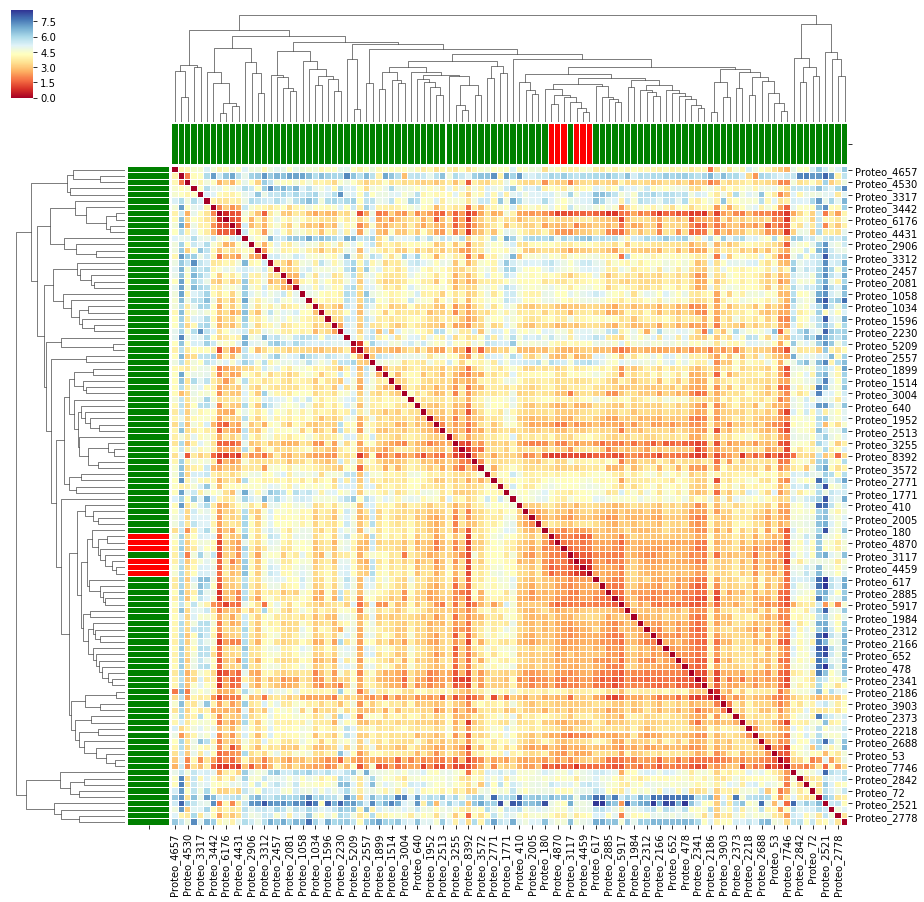

In [139]:
df = pd.DataFrame(data=distance_matrix.values,
                  index=distance_matrix.get_names(),
                  columns=distance_matrix.get_names())

colors = {group:'r' for group in nifHDKENB}
colors.update({group:'g' for group in groups})
row_linkage = linkage(y=squareform(df.values), method='complete')
sns.clustermap(df, row_linkage=row_linkage, col_linkage=row_linkage,
               figsize=(15,15), cmap='RdYlBu', linewidth=0.01,
               row_colors=pd.Series(colors), col_colors=pd.Series(colors))